# SPE DATATHON 


**Required packages**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style

# Load and preprocess data

In [11]:
# Load and preprocess data
wells_data = pd.read_csv('data/spe_africa_dseats_datathon_2025_wells_dataset.csv')
reservoir_info = pd.read_csv('data/reservoir_info.csv')
classification_params = pd.read_csv('data/classification_parameters.csv')

In [16]:
wells_data.head()

,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,2014-02-15,Well_#1,0.0,"4,050",189.866,0,1.17951,482.46,50.864,0,0,0,0
1,2014-02-16,Well_#1,0.0,"3,961",189.945,0,2.99440,328.601,47.668,0,0,0,0
2,2014-02-17,Well_#1,0.0,"3,961",190.004,0,1.90349,387.218,48.962,0,0,0,0
3,2014-02-18,Well_#1,0.0,"3,964",190.020,0,0.00000,308.98,46.636,0,0,0,0
4,2014-02-19,Well_#1,0.0,"3,965",190.107,0,30.20760,196.057,47.297,0,0,0,0


In [17]:
reservoir_info.head()

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,3500.0,3300.0,2700.0,800.0,1.20
1,KEMA,4200.0,4000.0,3900.0,600.0,1.45
2,MAKO,3500.0,3500.0,3000.0,500.0,1.15
3,DEPU,2800.0,2800.0,2400.0,1200.0,1.37
4,JANI,4500.0,4300.0,4200.0,1000.0,1.30


In [18]:
classification_params.head()

,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR Trend,Watercut Trend,Oil Productivity Index Trend
0,ACHI,Saturated,NF,Steady,aSolGOR,Flat,Flat
1,KEMA,Undersat,GL,Unsteady,bSolGOR,Incr,Incr
2,MAKO,NaN,NaN,NaN,Combo,Decr,Decr
3,DEPU,NaN,NaN,NaN,NaN,Combo,Combo
4,JANI,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
print(f"Wells data shape: {wells_data.shape}")
print(f"Reservoir info shape: {reservoir_info.shape}")
print(f"Classification params shape: {classification_params.shape}")

Wells data shape: (7955, 13)
Reservoir info shape: (5, 6)
Classification params shape: (5, 7)


In [21]:
# Clean numeric columns in reservoir_info (handle comma-separated numbers)
def clean_numeric_column(series):
    """Clean numeric columns that may contain commas"""
    if series.dtype == 'object':
        return pd.to_numeric(series.astype(str).str.replace(',', ''), errors='coerce')
    return series

# Clean reservoir_info numeric columns
numeric_cols_reservoir = ['Initial Reservoir Pressure (PSI)', 'Bubble Point Pressure (PSI)', 
                         'Current Average Reservoir Pressure (PSI)', 'Solution Gas-Oil-Ratio (SCF/BBL)']

for col in numeric_cols_reservoir:
    reservoir_info[col] = clean_numeric_column(reservoir_info[col])

print("Reservoir info after cleaning:")
print(reservoir_info.dtypes)

# Clean wells_data numeric columns
numeric_cols_wells = ['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'ANNULUS_PRESS (PSI)', 
                     'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)',
                     'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_TOTAL_GAS_PROD (MSCF)',
                     'CUMULATIVE_WATER_PROD (BBL)']

for col in numeric_cols_wells:
    if col in wells_data.columns:
        wells_data[col] = clean_numeric_column(wells_data[col])

Reservoir info after cleaning:
Reservoir Name                               object
Initial Reservoir Pressure (PSI)            float64
Bubble Point Pressure (PSI)                 float64
Current Average Reservoir Pressure (PSI)    float64
Solution Gas-Oil-Ratio (SCF/BBL)            float64
Formation Volume Factor (RB/STB)            float64
dtype: object


In [22]:
# =====================
# ENHANCED DATA PREPROCESSING
# =====================

def preprocess_well_data(df):
    """Enhanced preprocessing with better error handling"""
    # Convert date and sort
    df['PROD_DATE'] = pd.to_datetime(df['PROD_DATE'], format='%d-%b-%y')
    df = df.sort_values(['WELL_NAME', 'PROD_DATE'])
    
    # Calculate daily production rates with improved logic
    df['DAYS_DIFF'] = df.groupby('WELL_NAME')['PROD_DATE'].diff().dt.days
    df['DAYS_DIFF'] = df['DAYS_DIFF'].fillna(1)  # Fill first day with 1
    
    # Calculate rates based on cumulative production differences
    df['OIL_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_OIL_PROD (STB)'].diff()
    df['GAS_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff()
    df['WATER_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_WATER_PROD (BBL)'].diff()
    
    # Calculate daily rates
    df['OIL_RATE'] = df['OIL_DIFF'] / df['DAYS_DIFF']
    df['GAS_RATE'] = df['GAS_DIFF'] / df['DAYS_DIFF']
    df['WATER_RATE'] = df['WATER_DIFF'] / df['DAYS_DIFF']
    
    # Fill first values for each well (set to 0 for rates)
    df['OIL_RATE'] = df['OIL_RATE'].fillna(0)
    df['GAS_RATE'] = df['GAS_RATE'].fillna(0)
    df['WATER_RATE'] = df['WATER_RATE'].fillna(0)
    
    # Calculate GOR and Watercut with safe division
    df['GOR'] = np.where(df['OIL_RATE'] > 0, df['GAS_RATE'] / df['OIL_RATE'], 0)
    df['TOTAL_LIQUID'] = df['OIL_RATE'] + df['WATER_RATE']
    df['WATERCUT'] = np.where(df['TOTAL_LIQUID'] > 0, df['WATER_RATE'] / df['TOTAL_LIQUID'], 0)
    
    # Clean infinite and negative values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['GOR'] = df['GOR'].clip(lower=0, upper=10000)  # Reasonable GOR limits
    df['WATERCUT'] = df['WATERCUT'].clip(lower=0, upper=1)  # Watercut between 0-1
    
    return df

wells_data = preprocess_well_data(wells_data)
print(f"Wells data after preprocessing: {wells_data.shape}")


Wells data after preprocessing: (7955, 23)


In [23]:
# =====================
# ENHANCED FEATURE ENGINEERING
# =====================

def calculate_well_features(df, min_days=30):
    """Calculate comprehensive well-level features"""
    features = []
    
    for well in df['WELL_NAME'].unique():
        well_data = df[df['WELL_NAME'] == well].copy()
        
        # Skip wells with insufficient data
        if len(well_data) < min_days:
            continue
            
        # Basic statistics
        feature_dict = {
            'WELL_NAME': well,
            'DATA_POINTS': len(well_data),
            'PRODUCTION_DAYS': (well_data['PROD_DATE'].max() - well_data['PROD_DATE'].min()).days,
            
            # Pressure features
            'AVG_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].mean(),
            'MIN_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].min(),
            'MAX_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max(),
            'STD_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].std(),
            
            # Production features
            'AVG_OIL_RATE': well_data['OIL_RATE'].mean(),
            'MAX_OIL_RATE': well_data['OIL_RATE'].max(),
            'AVG_GAS_RATE': well_data['GAS_RATE'].mean(),
            'AVG_WATER_RATE': well_data['WATER_RATE'].mean(),
            
            # Cumulative production
            'TOTAL_OIL': well_data['CUMULATIVE_OIL_PROD (STB)'].iloc[-1],
            'TOTAL_GAS': well_data['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].iloc[-1],
            'TOTAL_WATER': well_data['CUMULATIVE_WATER_PROD (BBL)'].iloc[-1],
            
            # Ratios
            'AVG_GOR': well_data['GOR'].mean(),
            'MAX_GOR': well_data['GOR'].max(),
            'AVG_WATERCUT': well_data['WATERCUT'].mean(),
            'MAX_WATERCUT': well_data['WATERCUT'].max(),
            
            # Temperature
            'AVG_TEMP': well_data['DOWNHOLE_TEMPERATURE (deg F)'].mean(),
            
            # Choke size
            'AVG_CHOKE': well_data['CHOKE_SIZE (%)'].mean(),
            
            # Well head pressure
            'AVG_WHP': well_data['WELL_HEAD_PRESSURE (PSI)'].mean(),
        }
        
        # Calculate trends for recent data (last 30% of data points)
        recent_data = well_data.tail(max(10, len(well_data) // 3))
        if len(recent_data) > 5:
            # Oil rate trend
            oil_trend = np.polyfit(range(len(recent_data)), recent_data['OIL_RATE'], 1)[0]
            feature_dict['OIL_RATE_TREND'] = 'Incr' if oil_trend > 0.1 else ('Decr' if oil_trend < -0.1 else 'Flat')
            
            # GOR trend
            gor_trend = np.polyfit(range(len(recent_data)), recent_data['GOR'], 1)[0]
            feature_dict['GOR_TREND'] = 'Incr' if gor_trend > 1 else ('Decr' if gor_trend < -1 else 'Flat')
            
            # Watercut trend
            wc_trend = np.polyfit(range(len(recent_data)), recent_data['WATERCUT'], 1)[0]
            feature_dict['WATERCUT_TREND'] = 'Incr' if wc_trend > 0.01 else ('Decr' if wc_trend < -0.01 else 'Flat')
        else:
            feature_dict.update({
                'OIL_RATE_TREND': 'Flat',
                'GOR_TREND': 'Flat', 
                'WATERCUT_TREND': 'Flat'
            })
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

well_features = calculate_well_features(wells_data)
print(f"Well features calculated for {len(well_features)} wells")

Well features calculated for 20 wells


In [24]:
# =====================
# IMPROVED RESERVOIR MAPPING
# =====================

def map_wells_to_reservoirs(well_features, reservoir_info, pressure_threshold=300):
    """Map wells to reservoirs using multiple criteria"""
    mapping_results = []
    
    for _, well in well_features.iterrows():
        best_match = None
        min_score = float('inf')
        
        for _, reservoir in reservoir_info.iterrows():
            # Pressure difference score (primary criterion)
            pressure_diff = abs(well['AVG_BHP'] - reservoir['Current Average Reservoir Pressure (PSI)'])
            
            if pressure_diff <= pressure_threshold:
                # Composite score including GOR similarity
                gor_diff = abs(well['AVG_GOR'] - reservoir['Solution Gas-Oil-Ratio (SCF/BBL)'])
                composite_score = pressure_diff + (gor_diff * 0.1)  # Weight GOR less than pressure
                
                if composite_score < min_score:
                    min_score = composite_score
                    best_match = reservoir['Reservoir Name']
        
        mapping_results.append({
            'WELL_NAME': well['WELL_NAME'],
            'RESERVOIR': best_match,
            'MATCH_SCORE': min_score if best_match else None
        })
    
    return pd.DataFrame(mapping_results)

# Map wells to reservoirs
reservoir_mapping = map_wells_to_reservoirs(well_features, reservoir_info)
well_features = well_features.merge(reservoir_mapping, on='WELL_NAME')

# Show mapping results
print("\nReservoir mapping results:")
mapping_summary = well_features['RESERVOIR'].value_counts(dropna=False)
print(mapping_summary)


Reservoir mapping results:
DEPU    7
None    5
MAKO    4
KEMA    2
ACHI    2
Name: RESERVOIR, dtype: int64


In [26]:
# Clean numeric columns in reservoir_info (handle comma-separated numbers)
def clean_numeric_column(series):
    """Clean numeric columns that may contain commas"""
    if series.dtype == 'object':
        return pd.to_numeric(series.astype(str).str.replace(',', ''), errors='coerce')
    return series

# Clean reservoir_info numeric columns
numeric_cols_reservoir = ['Initial Reservoir Pressure (PSI)', 'Bubble Point Pressure (PSI)', 
                         'Current Average Reservoir Pressure (PSI)', 'Solution Gas-Oil-Ratio (SCF/BBL)']

for col in numeric_cols_reservoir:
    reservoir_info[col] = clean_numeric_column(reservoir_info[col])

print("Reservoir info after cleaning:")
print(reservoir_info.dtypes)

# Clean wells_data numeric columns
numeric_cols_wells = ['BOTTOMHOLE_FLOWING_PRESSURE (PSI)', 'ANNULUS_PRESS (PSI)', 
                     'WELL_HEAD_PRESSURE (PSI)', 'CUMULATIVE_OIL_PROD (STB)',
                     'CUMULATIVE_FORMATION_GAS_PROD (MSCF)', 'CUMULATIVE_TOTAL_GAS_PROD (MSCF)',
                     'CUMULATIVE_WATER_PROD (BBL)']

for col in numeric_cols_wells:
    if col in wells_data.columns:
        wells_data[col] = clean_numeric_column(wells_data[col])

# =====================
# ENHANCED DATA PREPROCESSING
# =====================

def preprocess_well_data(df):
    """Enhanced preprocessing with better error handling"""
    # Convert date and sort
    df['PROD_DATE'] = pd.to_datetime(df['PROD_DATE'], format='%d-%b-%y')
    df = df.sort_values(['WELL_NAME', 'PROD_DATE'])
    
    # Calculate daily production rates with improved logic
    df['DAYS_DIFF'] = df.groupby('WELL_NAME')['PROD_DATE'].diff().dt.days
    df['DAYS_DIFF'] = df['DAYS_DIFF'].fillna(1)  # Fill first day with 1
    
    # Calculate rates based on cumulative production differences
    df['OIL_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_OIL_PROD (STB)'].diff()
    df['GAS_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].diff()
    df['WATER_DIFF'] = df.groupby('WELL_NAME')['CUMULATIVE_WATER_PROD (BBL)'].diff()
    
    # Calculate daily rates
    df['OIL_RATE'] = df['OIL_DIFF'] / df['DAYS_DIFF']
    df['GAS_RATE'] = df['GAS_DIFF'] / df['DAYS_DIFF']
    df['WATER_RATE'] = df['WATER_DIFF'] / df['DAYS_DIFF']
    
    # Fill first values for each well (set to 0 for rates)
    df['OIL_RATE'] = df['OIL_RATE'].fillna(0)
    df['GAS_RATE'] = df['GAS_RATE'].fillna(0)
    df['WATER_RATE'] = df['WATER_RATE'].fillna(0)
    
    # Calculate GOR and Watercut with safe division
    df['GOR'] = np.where(df['OIL_RATE'] > 0, df['GAS_RATE'] / df['OIL_RATE'], 0)
    df['TOTAL_LIQUID'] = df['OIL_RATE'] + df['WATER_RATE']
    df['WATERCUT'] = np.where(df['TOTAL_LIQUID'] > 0, df['WATER_RATE'] / df['TOTAL_LIQUID'], 0)
    
    # Clean infinite and negative values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['GOR'] = df['GOR'].clip(lower=0, upper=10000)  # Reasonable GOR limits
    df['WATERCUT'] = df['WATERCUT'].clip(lower=0, upper=1)  # Watercut between 0-1
    
    return df

wells_data = preprocess_well_data(wells_data)
print(f"Wells data after preprocessing: {wells_data.shape}")

Reservoir info after cleaning:
Reservoir Name                               object
Initial Reservoir Pressure (PSI)            float64
Bubble Point Pressure (PSI)                 float64
Current Average Reservoir Pressure (PSI)    float64
Solution Gas-Oil-Ratio (SCF/BBL)            float64
Formation Volume Factor (RB/STB)            float64
dtype: object
Wells data after preprocessing: (7955, 23)


In [27]:
# =====================
# ENHANCED FEATURE ENGINEERING
# =====================

def calculate_well_features(df, min_days=30):
    """Calculate comprehensive well-level features"""
    features = []
    
    for well in df['WELL_NAME'].unique():
        well_data = df[df['WELL_NAME'] == well].copy()
        
        # Skip wells with insufficient data
        if len(well_data) < min_days:
            continue
            
        # Basic statistics
        feature_dict = {
            'WELL_NAME': well,
            'DATA_POINTS': len(well_data),
            'PRODUCTION_DAYS': (well_data['PROD_DATE'].max() - well_data['PROD_DATE'].min()).days,
            
            # Pressure features
            'AVG_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].mean(),
            'MIN_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].min(),
            'MAX_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].max(),
            'STD_BHP': well_data['BOTTOMHOLE_FLOWING_PRESSURE (PSI)'].std(),
            
            # Production features
            'AVG_OIL_RATE': well_data['OIL_RATE'].mean(),
            'MAX_OIL_RATE': well_data['OIL_RATE'].max(),
            'AVG_GAS_RATE': well_data['GAS_RATE'].mean(),
            'AVG_WATER_RATE': well_data['WATER_RATE'].mean(),
            
            # Cumulative production
            'TOTAL_OIL': well_data['CUMULATIVE_OIL_PROD (STB)'].iloc[-1],
            'TOTAL_GAS': well_data['CUMULATIVE_FORMATION_GAS_PROD (MSCF)'].iloc[-1],
            'TOTAL_WATER': well_data['CUMULATIVE_WATER_PROD (BBL)'].iloc[-1],
            
            # Ratios
            'AVG_GOR': well_data['GOR'].mean(),
            'MAX_GOR': well_data['GOR'].max(),
            'AVG_WATERCUT': well_data['WATERCUT'].mean(),
            'MAX_WATERCUT': well_data['WATERCUT'].max(),
            
            # Temperature
            'AVG_TEMP': well_data['DOWNHOLE_TEMPERATURE (deg F)'].mean(),
            
            # Choke size
            'AVG_CHOKE': well_data['CHOKE_SIZE (%)'].mean(),
            
            # Well head pressure
            'AVG_WHP': well_data['WELL_HEAD_PRESSURE (PSI)'].mean(),
        }
        
        # Calculate trends for recent data (last 30% of data points)
        recent_data = well_data.tail(max(10, len(well_data) // 3))
        if len(recent_data) > 5:
            # Oil rate trend - map to valid categories
            oil_trend = np.polyfit(range(len(recent_data)), recent_data['OIL_RATE'], 1)[0]
            if oil_trend > 0.1:
                feature_dict['OIL_RATE_TREND'] = 'Incr'
            elif oil_trend < -0.1:
                feature_dict['OIL_RATE_TREND'] = 'Decr'
            else:
                feature_dict['OIL_RATE_TREND'] = 'Flat'
            
            # GOR trend - map to Formation GOR Trend categories
            gor_trend = np.polyfit(range(len(recent_data)), recent_data['GOR'], 1)[0]
            if gor_trend > 5:
                feature_dict['GOR_TREND'] = 'bSolGOR'  # Increasing GOR
            elif gor_trend < -5:
                feature_dict['GOR_TREND'] = 'aSolGOR'  # Decreasing GOR
            else:
                feature_dict['GOR_TREND'] = 'aSolGOR'  # Stable/low change
            
            # Watercut trend - ensure valid categories
            wc_trend = np.polyfit(range(len(recent_data)), recent_data['WATERCUT'], 1)[0]
            if wc_trend > 0.01:
                feature_dict['WATERCUT_TREND'] = 'Incr'
            elif wc_trend < -0.01:
                feature_dict['WATERCUT_TREND'] = 'Decr'  
            else:
                feature_dict['WATERCUT_TREND'] = 'Flat'
        else:
            # Default values for insufficient data
            feature_dict['OIL_RATE_TREND'] = 'Flat'
            feature_dict['GOR_TREND'] = 'aSolGOR'
            feature_dict['WATERCUT_TREND'] = 'Flat'
        
        features.append(feature_dict)
    
    return pd.DataFrame(features)

well_features = calculate_well_features(wells_data)
print(f"Well features calculated for {len(well_features)} wells")

Well features calculated for 20 wells


In [41]:

# =====================
# IMPROVED RESERVOIR MAPPING
# =====================

def map_wells_to_reservoirs(well_features, reservoir_info, pressure_threshold=300):
    """Map wells to reservoirs using multiple criteria"""
    mapping_results = []
    
    for _, well in well_features.iterrows():
        best_match = None
        min_score = float('inf')
        
        for _, reservoir in reservoir_info.iterrows():
            # Pressure difference score (primary criterion)
            pressure_diff = abs(well['AVG_BHP'] - reservoir['Current Average Reservoir Pressure (PSI)'])
            
            if pressure_diff <= pressure_threshold:
                # Composite score including GOR similarity
                gor_diff = abs(well['AVG_GOR'] - reservoir['Solution Gas-Oil-Ratio (SCF/BBL)'])
                composite_score = pressure_diff + (gor_diff * 0.1)  # Weight GOR less than pressure
                
                if composite_score < min_score:
                    min_score = composite_score
                    best_match = reservoir['Reservoir Name']
        
        mapping_results.append({
            'WELL_NAME': well['WELL_NAME'],
            'RESERVOIR': best_match,
            'MATCH_SCORE': min_score if best_match else None
        })
    
    return pd.DataFrame(mapping_results)

# Map wells to reservoirs
reservoir_mapping = map_wells_to_reservoirs(well_features, reservoir_info)
well_features = well_features.merge(reservoir_mapping, on='WELL_NAME')

# Show mapping results
print("\nReservoir mapping results:")
mapping_summary = well_features['RESERVOIR'].value_counts(dropna=False)
print(mapping_summary)

# =====================
# ENHANCED MODEL TRAINING
# =====================

# Prepare features for modeling
model_features = well_features.merge(
    reservoir_info, 
    left_on='RESERVOIR', 
    right_on='Reservoir Name', 
    how='left'
)

# Define feature columns for the model
feature_cols = [
    'AVG_BHP', 'MIN_BHP', 'MAX_BHP', 'STD_BHP',
    'AVG_OIL_RATE', 'MAX_OIL_RATE', 'AVG_GAS_RATE', 'AVG_WATER_RATE',
    'AVG_GOR', 'MAX_GOR', 'AVG_WATERCUT', 'MAX_WATERCUT',
    'AVG_TEMP', 'AVG_CHOKE', 'AVG_WHP',
    'TOTAL_OIL', 'TOTAL_GAS', 'TOTAL_WATER',
    'DATA_POINTS', 'PRODUCTION_DAYS',
    'Initial Reservoir Pressure (PSI)', 'Bubble Point Pressure (PSI)',
    'Current Average Reservoir Pressure (PSI)', 'Solution Gas-Oil-Ratio (SCF/BBL)',
    'Formation Volume Factor (RB/STB)'
]

# Prepare X matrix
X = model_features[feature_cols].copy()

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Prepare target variables
target_data = classification_params.copy()

# First, let's examine the actual values in classification_params to define proper categories
print("Examining classification parameters values:")
actual_categories = {}
for col in ['Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']:
    if col in target_data.columns:
        unique_vals = target_data[col].dropna().unique()
        actual_categories[col] = list(unique_vals)
        print(f"{col}: {unique_vals}")

# Define comprehensive category orders based on actual data plus expected values
category_orders = {
    'Reservoir Type': list(set(['Saturated', 'Undersat', 'Unknown'] + actual_categories.get('Reservoir Type', []))),
    'Well Type': list(set(['NF', 'GL', 'Unknown'] + actual_categories.get('Well Type', []))),
    'Production Type': list(set(['Steady', 'Unsteady', 'Unknown'] + actual_categories.get('Production Type', []))),
    'Formation GOR Trend': list(set(['aSolGOR', 'bSolGOR', 'Combo', 'Unknown'] + actual_categories.get('Formation GOR Trend', []))),
    'Watercut Trend': list(set(['Flat', 'Incr', 'Decr', 'Combo', 'Unknown'] + actual_categories.get('Watercut Trend', []))),
    'Oil Productivity Index Trend': list(set(['Flat', 'Incr', 'Decr', 'Combo', 'Unknown'] + actual_categories.get('Oil Productivity Index Trend', [])))
}

print("\nFinal category orders:")
for col, cats in category_orders.items():
    print(f"{col}: {cats}")

# First, let's examine the actual values in classification_params to define proper categories
print("Examining classification parameters values:")
for col in ['Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']:
    if col in target_data.columns:
        unique_vals = target_data[col].dropna().unique()
        print(f"{col}: {unique_vals}")

# Define comprehensive category orders including all possible values
category_orders = {
    'Reservoir Type': ['Saturated', 'Undersat', 'Unknown'],
    'Well Type': ['NF', 'GL', 'Unknown'],
    'Production Type': ['Steady', 'Unsteady', 'Unknown'],
    'Formation GOR Trend': ['aSolGOR', 'bSolGOR', 'Combo', 'Unknown'],
    'Watercut Trend': ['Flat', 'Incr', 'Decr', 'Combo', 'Unknown'],
    'Oil Productivity Index Trend': ['Flat', 'Incr', 'Decr', 'Combo', 'Unknown']
}

# Fill missing values and encode
label_encoders = {}
for col, categories in category_orders.items():
    if col in target_data.columns:
        # Fill missing values with 'Unknown'
        target_data[col] = target_data[col].fillna('Unknown')
        
        # Check if all values in target_data are in our categories
        unique_vals = target_data[col].unique()
        missing_categories = [val for val in unique_vals if val not in categories]
        
        if missing_categories:
            print(f"Warning: Found unexpected values in {col}: {missing_categories}")
            # Add unexpected values to categories
            categories.extend(missing_categories)
            category_orders[col] = categories
        
        # Create and fit label encoder
        le = LabelEncoder()
        le.fit(categories)
        label_encoders[col] = le
    else:
        print(f"Warning: Column {col} not found in target data")

# Map targets to wells through reservoirs
well_targets = model_features[['WELL_NAME', 'RESERVOIR']].merge(
    target_data, 
    left_on='RESERVOIR', 
    right_on='Reservoir Name',
    how='left'
)

# Encode target variables with better error handling
y_encoded = pd.DataFrame()
for col in category_orders.keys():
    if col in well_targets.columns:
        # Fill missing values for unmapped wells with 'Unknown'
        well_targets[col] = well_targets[col].fillna('Unknown')
        
        # Handle any values not seen during encoder fitting
        unique_vals = well_targets[col].unique()
        unseen_vals = [val for val in unique_vals if val not in label_encoders[col].classes_]
        
        if unseen_vals:
            print(f"Warning: Unseen values in {col}: {unseen_vals}")
            # Replace unseen values with 'Unknown'
            well_targets[col] = well_targets[col].replace(unseen_vals, 'Unknown')
        
        try:
            y_encoded[col] = label_encoders[col].transform(well_targets[col])
        except ValueError as e:
            print(f"Error encoding {col}: {e}")
            # Fallback: encode as 'Unknown' (last category)
            y_encoded[col] = [len(label_encoders[col].classes_) - 1] * len(well_targets)

print(f"Training data shape: X={X_imputed.shape}, y={y_encoded.shape}")


Reservoir mapping results:
DEPU    7
None    5
MAKO    4
KEMA    2
ACHI    2
Name: RESERVOIR, dtype: int64
Examining classification parameters values:
Reservoir Type: ['Saturated' 'Undersat']
Well Type: ['NF' 'GL']
Production Type: ['Steady' 'Unsteady']
Formation GOR Trend: ['aSolGOR' 'bSolGOR' 'Combo']
Watercut Trend: ['Flat' 'Incr' 'Decr' 'Combo']
Oil Productivity Index Trend: ['Flat' 'Incr' 'Decr' 'Combo']

Final category orders:
Reservoir Type: ['Saturated', 'Unknown', 'Undersat']
Well Type: ['GL', 'Unknown', 'NF']
Production Type: ['Steady', 'Unknown', 'Unsteady']
Formation GOR Trend: ['bSolGOR', 'Combo', 'aSolGOR', 'Unknown']
Watercut Trend: ['Flat', 'Incr', 'Decr', 'Unknown', 'Combo']
Oil Productivity Index Trend: ['Flat', 'Incr', 'Decr', 'Unknown', 'Combo']
Examining classification parameters values:
Reservoir Type: ['Saturated' 'Undersat']
Well Type: ['NF' 'GL']
Production Type: ['Steady' 'Unsteady']
Formation GOR Trend: ['aSolGOR' 'bSolGOR' 'Combo']
Watercut Trend: ['Flat' '

In [33]:
# =====================
# MODEL TRAINING AND EVALUATION
# =====================

if len(y_encoded) > 0 and len(X_imputed) > 0:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_encoded, test_size=0.3, random_state=42, stratify=None
    )
    
    # Train enhanced model
    model = MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
    )
    
    print("Training model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy for each output
    print("\n=== MODEL PERFORMANCE ===")
    overall_accuracies = []
    
    for i, col in enumerate(category_orders.keys()):
        if i < y_pred.shape[1]:
            acc = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
            overall_accuracies.append(acc)
            print(f"{col}: {acc:.3f}")
    
    print(f"Average Accuracy: {np.mean(overall_accuracies):.3f}")

Training model...

=== MODEL PERFORMANCE ===
Reservoir Type: 0.667
Well Type: 0.667
Production Type: 0.667
Formation GOR Trend: 0.667
Watercut Trend: 0.667
Oil Productivity Index Trend: 0.667
Average Accuracy: 0.667


In [37]:
 #=====================
    # FINAL PREDICTIONS AND BARREL CALCULATION
    # =====================
    
    # Make predictions for all wells
final_predictions = model.predict(X_imputed)
    
    # Create results dataframe
results = well_features[['WELL_NAME', 'RESERVOIR']].copy()
    
    # Decode predictions with error handling
for i, col in enumerate(category_orders.keys()):
    if i < final_predictions.shape[1]:
        try:
                # Ensure predictions are within valid range
            predictions_clipped = np.clip(final_predictions[:, i], 0, len(label_encoders[col].classes_) - 1)
            results[col] = label_encoders[col].inverse_transform(predictions_clipped.astype(int))
        except Exception as e:
            print(f"Error decoding {col}: {e}")
            results[col] = 'Unknown'  # Fallback value
    
    # Calculate reservoir barrel production
reservoir_production = results.merge(
    well_features[['WELL_NAME', 'TOTAL_OIL']], 
    on='WELL_NAME'
).merge(
    reservoir_info[['Reservoir Name', 'Formation Volume Factor (RB/STB)']],
    left_on='RESERVOIR', 
    right_on='Reservoir Name',
    how='left'
)
    
    # Handle missing formation volume factors
reservoir_production['Formation Volume Factor (RB/STB)'] = reservoir_production['Formation Volume Factor (RB/STB)'].fillna(1.0)
    
    # Calculate reservoir barrels
reservoir_production['RESERVOIR_BBL'] = (
    reservoir_production['TOTAL_OIL'] * 
    reservoir_production['Formation Volume Factor (RB/STB)']
)
    
    # Summary by reservoir
reservoir_summary = reservoir_production.groupby('RESERVOIR').agg({
    'RESERVOIR_BBL': 'sum',
    'WELL_NAME': 'count'
}).rename(columns={'WELL_NAME': 'WELL_COUNT'})
    
print("\n=== RESERVOIR PRODUCTION SUMMARY ===")
print(reservoir_summary)
    


=== RESERVOIR PRODUCTION SUMMARY ===
           RESERVOIR_BBL  WELL_COUNT
RESERVOIR                           
ACHI           354730.80           2
DEPU          2459488.39           7
KEMA           343940.00           2
MAKO           338749.75           4


In [38]:
# =====================
# SAVE RESULTS
# =====================
    
team_name = "Data_PhandasRF"  # Replace with your team name
    
# Save classification results
results.to_csv(f'{team_name}_DSEATS_Africa_2025_Classification.csv', index=False)
    
# Save reservoir production
reservoir_summary.to_csv(f'{team_name}_Reservoir_Production.csv')
    
print(f"\n=== FILES SAVED ===")
print(f"1. {team_name}_DSEATS_Africa_2025_Classification.csv")
print(f"2. {team_name}_Reservoir_Production.csv")
print(f"\nTotal wells classified: {len(results)}")
print(f"Wells mapped to reservoirs: {len(results[results['RESERVOIR'].notna()])}")
    
    # Show sample results
print("\n=== SAMPLE RESULTS ===")
print(results.head(10))


=== FILES SAVED ===
1. Data_PhandasRF_DSEATS_Africa_2025_Classification.csv
2. Data_PhandasRF_Reservoir_Production.csv

Total wells classified: 20
Wells mapped to reservoirs: 15

=== SAMPLE RESULTS ===
  WELL_NAME RESERVOIR Reservoir Type Well Type Production Type  \
0   Well_#1      MAKO        Unknown   Unknown         Unknown   
1  Well_#10      KEMA        Unknown   Unknown         Unknown   
2  Well_#11      DEPU        Unknown   Unknown         Unknown   
3  Well_#12      None        Unknown   Unknown         Unknown   
4  Well_#13      None        Unknown   Unknown         Unknown   
5  Well_#14      DEPU        Unknown   Unknown         Unknown   
6  Well_#15      MAKO        Unknown   Unknown         Unknown   
7  Well_#16      ACHI      Saturated        NF          Steady   
8  Well_#17      None        Unknown   Unknown         Unknown   
9  Well_#18      DEPU        Unknown   Unknown         Unknown   

  Formation GOR Trend Watercut Trend Oil Productivity Index Trend  
0 

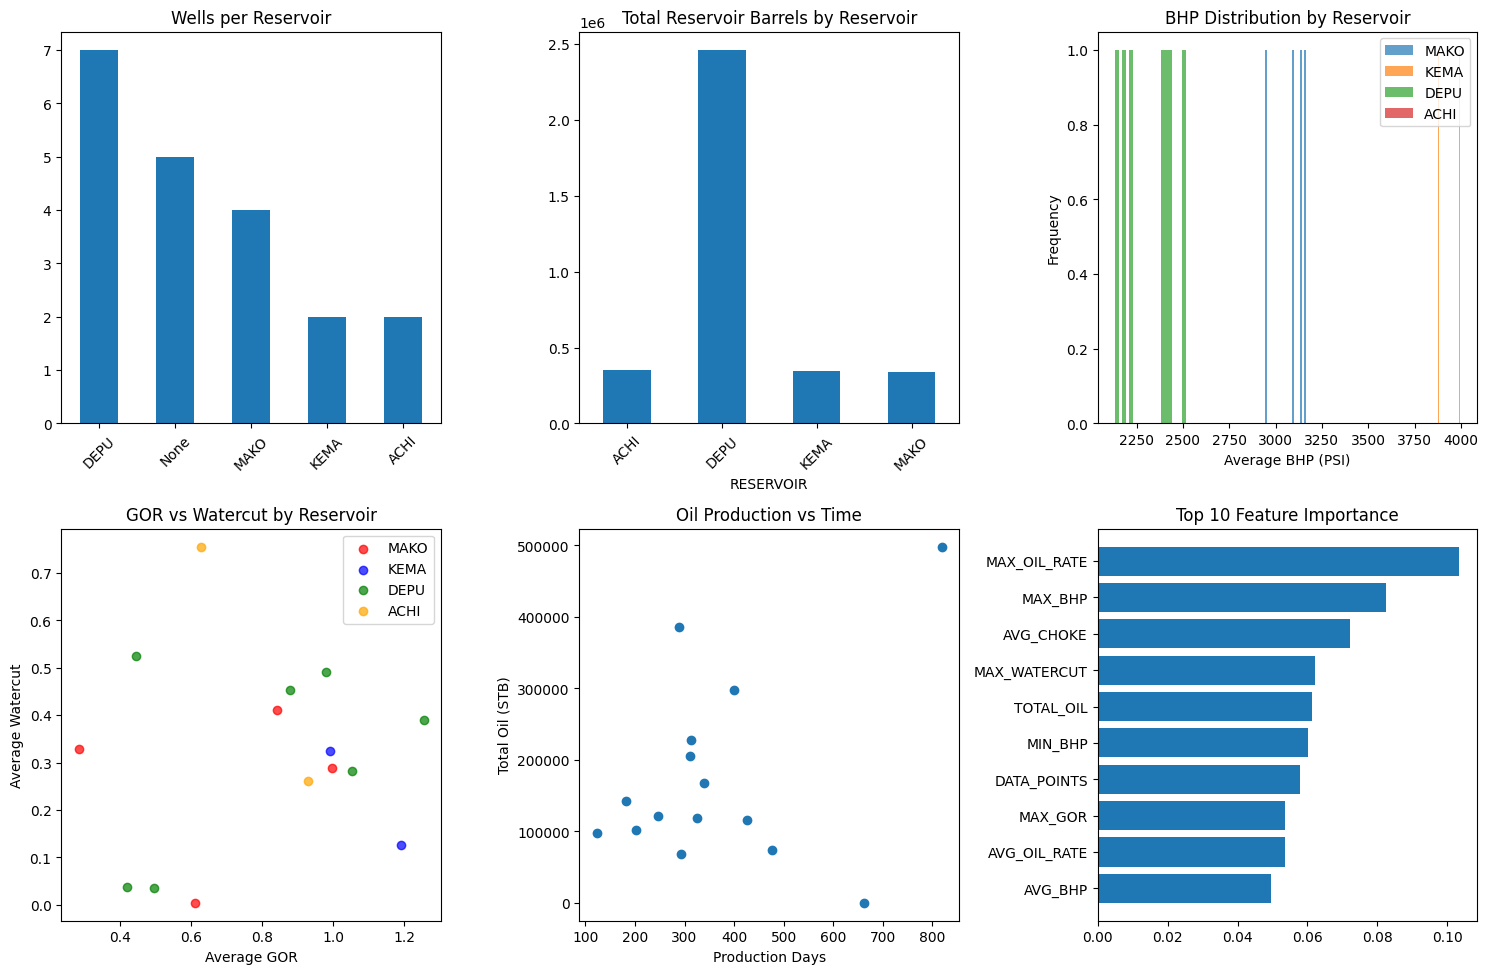

In [39]:
# =====================
# VISUALIZATION
# =====================

plt.figure(figsize=(15, 10))

# Plot 1: Wells per reservoir
plt.subplot(2, 3, 1)
mapping_summary.plot(kind='bar')
plt.title('Wells per Reservoir')
plt.xticks(rotation=45)

# Plot 2: Oil production by reservoir
if 'reservoir_production' in locals():
    plt.subplot(2, 3, 2)
    reservoir_summary['RESERVOIR_BBL'].plot(kind='bar')
    plt.title('Total Reservoir Barrels by Reservoir')
    plt.xticks(rotation=45)

# Plot 3: BHP distribution by reservoir
plt.subplot(2, 3, 3)
mapped_wells = well_features[well_features['RESERVOIR'].notna()]
if len(mapped_wells) > 0:
    for reservoir in mapped_wells['RESERVOIR'].unique():
        reservoir_wells = mapped_wells[mapped_wells['RESERVOIR'] == reservoir]
        plt.hist(reservoir_wells['AVG_BHP'], alpha=0.7, label=reservoir, bins=20)
    plt.xlabel('Average BHP (PSI)')
    plt.ylabel('Frequency')
    plt.title('BHP Distribution by Reservoir')
    plt.legend()

# Plot 4: GOR vs Watercut
plt.subplot(2, 3, 4)
if len(mapped_wells) > 0:
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, reservoir in enumerate(mapped_wells['RESERVOIR'].unique()):
        reservoir_wells = mapped_wells[mapped_wells['RESERVOIR'] == reservoir]
        plt.scatter(reservoir_wells['AVG_GOR'], reservoir_wells['AVG_WATERCUT'], 
                   alpha=0.7, label=reservoir, color=colors[i % len(colors)])
    plt.xlabel('Average GOR')
    plt.ylabel('Average Watercut')
    plt.title('GOR vs Watercut by Reservoir')
    plt.legend()

# Plot 5: Production timeline
plt.subplot(2, 3, 5)
if len(mapped_wells) > 0:
    plt.scatter(mapped_wells['PRODUCTION_DAYS'], mapped_wells['TOTAL_OIL'])
    plt.xlabel('Production Days')
    plt.ylabel('Total Oil (STB)')
    plt.title('Oil Production vs Time')

# Plot 6: Feature importance (if model exists)
if 'model' in locals() and hasattr(model.estimators_[0], 'feature_importances_'):
    plt.subplot(2, 3, 6)
    feature_importance = model.estimators_[0].feature_importances_
    top_features = np.argsort(feature_importance)[-10:]
    plt.barh(range(len(top_features)), feature_importance[top_features])
    plt.yticks(range(len(top_features)), [feature_cols[i] for i in top_features])
    plt.title('Top 10 Feature Importance')

plt.tight_layout()
plt.show()


# Feature engineering

In [6]:
# =====================
# FEATURE ENGINEERING
# =====================

def calculate_trends(df, window=30):
    """Enhanced production trend analysis with statistical features"""
    trends = pd.DataFrame()
    for well in df['well_id'].unique():
        well_data = df[df['well_id'] == well].sort_values('date')
        
        # Calculate statistical features
        for col in ['oil_rate', 'gas_rate', 'water_rate']:
            # Rolling statistics
            well_data[f'{col}_ma'] = well_data[col].rolling(window=window).mean()
            well_data[f'{col}_std'] = well_data[col].rolling(window=window).std()
            
            # Trend classification using the pre-defined encoders
            trend_labels = np.where(
                well_data[f'{col}_ma'].pct_change() > 0.1, 'Incr',
                np.where(well_data[f'{col}_ma'].pct_change() < -0.1, 'Decr', 'Flat'))
            well_data[f'{col}_trend'] = label_encoders[f'{col.split("_")[0]}_trend'].transform(trend_labels)
        
        trends = pd.concat([trends, well_data])
    return trends

def map_well_to_reservoir(well_data, reservoir_info):
    """Enhanced reservoir mapping with pressure differential analysis"""
    results = []
    pressure_diffs = []
    
    for _, well in well_data.iterrows():
        min_diff = float('inf')
        best_reservoir = None
        
        for _, reservoir in reservoir_info.iterrows():
            pressure_diff = abs(well['bottom_hole_pressure'] - reservoir['Current Average Reservoir Pressure (PSI)'])
            
            if pressure_diff < min_diff and pressure_diff <= 200:
                min_diff = pressure_diff
                best_reservoir = reservoir['Reservoir Name']
        
        results.append(best_reservoir)
        pressure_diffs.append(min_diff)
    
    return results, pressure_diffs

    # Apply feature engineering
    wells_data = calculate_trends(wells_data)
    wells_data['reservoir'], wells_data['pressure_diff'] = map_well_to_reservoir(wells_data, reservoir_info)

In [7]:
# =====================
# MODEL TRAINING
# =====================

# Prepare final features
features = wells_data.groupby('well_id').agg({
    'oil_rate': ['mean', 'std', 'max'],
    'gas_rate': ['mean', 'std'],
    'water_rate': ['mean', 'std'],
    'bottom_hole_pressure': 'mean',
    'oil_rate_trend': lambda x: x.mode()[0],
    'water_rate_trend': lambda x: x.mode()[0],
    'reservoir': 'first',
    'pressure_diff': 'mean'
}).reset_index()

features.columns = ['well_id', 'oil_mean', 'oil_std', 'oil_max', 'gas_mean', 'gas_std',
                   'water_mean', 'water_std', 'pressure_mean', 'oil_trend', 
                   'water_trend', 'reservoir', 'pressure_diff']

# Merge with reservoir info
features = features.merge(reservoir_info, left_on='reservoir', right_on='Reservoir Name', how='left')

# Prepare targets with consistent encoding
target = classification_params[classification_params['Reservoir Name'].isin(features['reservoir'])]
for col in category_orders.keys():
    # Fill NA with first valid value then encode
    target[col] = label_encoders[col].transform(target[col].fillna(target[col].dropna().iloc[0]))

KeyError: 'well_id'

In [ ]:
# Train-test split
X = features.drop(['well_id', 'reservoir', 'Reservoir Name'], axis=1)
y = target[list(category_orders.keys())]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train model with enhanced parameters
model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    n_jobs=-1
)
model.fit(X_train, y_train)

# =====================
# ENHANCED MODEL EVALUATION
# =====================

y_pred = model.predict(X_test)

def print_enhanced_classification_report(y_true, y_pred, label_encoders):
    """Custom reporting with decoded labels"""
    for i, col in enumerate(label_encoders.keys()):
        print(f"\n=== {col.upper()} CLASSIFICATION REPORT ===")
        le = label_encoders[col]
        print(classification_report(
            le.inverse_transform(y_true.iloc[:,i]),
            le.inverse_transform(y_pred[:,i]),
            target_names=le.classes_
        ))
        
        # Confusion matrix visualization
        plt.figure(figsize=(8,6))
        cm = confusion_matrix(
            le.inverse_transform(y_true.iloc[:,i]),
            le.inverse_transform(y_pred[:,i])
        )
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=le.classes_,
                   yticklabels=le.classes_)
        plt.title(f'Confusion Matrix - {col}')
        plt.show()

print_enhanced_classification_report(y_test, y_pred, label_encoders)

In [ ]:
# Feature importance analysis
plt.figure(figsize=(12, 8))
for i, estimator in enumerate(model.estimators_):
    plt.subplot(2, 3, i+1)
    importances = pd.Series(estimator.feature_importances_, index=X.columns)
    importances.nlargest(10).plot(kind='barh')
    plt.title(f'Top Features - {list(label_encoders.keys())[i]}')
plt.tight_layout()
plt.show()

In [ ]:
# =====================
# FINAL SUBMISSION
# =====================

# Generate and save final predictions
final_predictions = model.predict(features.drop(['well_id', 'reservoir', 'Reservoir Name'], axis=1))
submission = features[['well_id', 'reservoir']].copy()
for i, col in enumerate(label_encoders.keys()):
    submission[col] = label_encoders[col].inverse_transform(final_predictions[:,i])

team_name = "Data Phandas randomF"
submission.to_csv(f'{team_name}_DSEATS_Africa_2025_Classification.csv', index=False)

print("\n=== SUBMISSION FILE CREATED SUCCESSFULLY ===")
print(f"Saved as: {team_name}_DSEATS_Africa_2025_Classification.csv")

# Preparing multi classification

In [ ]:
# Prepare multi-output target
target_columns = ['Reservoir Name', 'Reservoir Type', 'Well Type', 
                 'Production Type', 'Formation GOR Trend',
                 'Watercut Trend', 'Oil Productivity Index Trend']

# Split data

# Train model

# Metrics evalution

# Production Calculation

In [ ]:
# Calculate total reservoir barrels per reservoir
reservoir_oil_production = wells_data.groupby('predicted_reservoir')['cumulative_oil'].sum()

# Convert to reservoir barrels using FVF
for reservoir in reservoir_info['Reservoir Name']:
    fvf = reservoir_info.loc[reservoir_info['Reservoir Name'] == reservoir, 'Oil Formation Volume Factor'].values[0]
    reservoir_oil_production[reservoir] *= fvf

# Submission Preparation

In [ ]:
# =====================
# MODEL TRAINING
# =====================

# Prepare final features
features = wells_data.groupby('well_id').agg({
    'oil_rate': ['mean', 'std', 'max'],
    'gas_rate': ['mean', 'std'],
    'water_rate': ['mean', 'std'],
    'bottom_hole_pressure': 'mean',
    'oil_rate_trend': lambda x: x.mode()[0],
    'water_rate_trend': lambda x: x.mode()[0],
    'reservoir': 'first',
    'pressure_diff': 'mean'
}).reset_index()

features.columns = ['well_id', 'oil_mean', 'oil_std', 'oil_max', 'gas_mean', 'gas_std',
                   'water_mean', 'water_std', 'pressure_mean', 'oil_trend', 
                   'water_trend', 'reservoir', 'pressure_diff']

# Merge with reservoir info
features = features.merge(reservoir_info, left_on='reservoir', right_on='Reservoir Name', how='left')

# Prepare targets
target = classification_params[classification_params['Reservoir Name'].isin(features['reservoir'])]
target_cols = ['Reservoir Type', 'Well Type', 'Production Type', 
               'Formation GOR Trend', 'Watercut Trend', 'Oil Productivity Index Trend']

# Encode categorical variables
label_encoders = {}
for col in ['oil_trend', 'water_trend'] + target_cols:
    le = LabelEncoder()
    if col in ['oil_trend', 'water_trend']:
        features[col] = le.fit_transform(features[col])
    else:
        target[col] = le.fit_transform(target[col].fillna('Unknown'))
    label_encoders[col] = le

In [ ]:
#Train-test split
X = features.drop(['well_id', 'reservoir', 'Reservoir Name'], axis=1)
y = target[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model with enhanced parameters
model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    )
)
model.fit(X_train, y_train)

In [ ]:
# =====================
# MODEL EVALUATION
# =====================

y_pred = model.predict(X_test)

# Enhanced classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=target_cols))

# Detailed metrics
metrics = []
for i, col in enumerate(target_cols):
    metrics.append({
        'Parameter': col,
        'Accuracy': accuracy_score(y_test.iloc[:,i], y_pred[:,i]),
        'Precision': precision_score(y_test.iloc[:,i], y_pred[:,i], average='weighted'),
        'Recall': recall_score(y_test.iloc[:,i], y_pred[:,i], average='weighted'),
        'F1-Score': f1_score(y_test.iloc[:,i], y_pred[:,i], average='weighted')
    })

print("\n=== DETAILED PERFORMANCE METRICS ===")
print(pd.DataFrame(metrics).to_string(index=False))

# Confusion matrices
plt.figure(figsize=(15, 20))
for i, col in enumerate(target_cols, 1):
    plt.subplot(3, 2, i)
    cm = confusion_matrix(y_test.iloc[:,i-1], y_pred[:,i-1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoders[col].classes_,
                yticklabels=label_encoders[col].classes_)
    plt.title(f'Confusion Matrix - {col}')
plt.tight_layout()
plt.show()

In [ ]:
# =====================
# FINAL PREDICTIONS & SUBMISSION
# =====================

# Generate final predictions
final_predictions = model.predict(features.drop(['well_id', 'reservoir', 'Reservoir Name'], axis=1))

# Create submission DataFrame
submission = pd.DataFrame({
    'Well': features['well_id'],
    'Reservoir Name': features['reservoir'],
    'Reservoir Type': label_encoders['Reservoir Type'].inverse_transform(final_predictions[:,0]),
    'Well Type': label_encoders['Well Type'].inverse_transform(final_predictions[:,1]),
    'Production Type': label_encoders['Production Type'].inverse_transform(final_predictions[:,2]),
    'Formation GOR Trend': label_encoders['Formation GOR Trend'].inverse_transform(final_predictions[:,3]),
    'Watercut Trend': label_encoders['Watercut Trend'].inverse_transform(final_predictions[:,4]),
    'Oil Productivity Index Trend': label_encoders['Oil Productivity Index Trend'].inverse_transform(final_predictions[:,5])
})

# Production analysis
reservoir_oil = wells_data.groupby('reservoir').agg({
    'cumulative_oil': 'sum',
    'oil_rate': 'mean'
}).reset_index()
reservoir_oil = reservoir_oil.merge(
    reservoir_info[['Reservoir Name', 'Formation Volume Factor (RB/STB)']],
    left_on='reservoir', right_on='Reservoir Name'
)
reservoir_oil['total_reservoir_barrels'] = reservoir_oil['cumulative_oil'] * reservoir_oil['Formation Volume Factor (RB/STB)']

# Save results
team_name = "Data Phandas_RF"
submission.to_csv(f'{team_name}_DSEATS_Africa_2025_Classification.csv', index=False)
reservoir_oil[['Reservoir Name', 'total_reservoir_barrels']].to_csv(
    f'{team_name}_reservoir_production.csv', index=False)

print("\n=== SUBMISSION FILES CREATED SUCCESSFULLY ===")
print(f"1. {team_name}_DSEATS_Africa_2025_Classification.csv")
print(f"2. {team_name}_reservoir_production.csv")